# Домашнее задание 5. Градиентный спуск. (10 баллов + 2.5 бонус)

В этом домашнем задании вы напишете градиентный спуск для линейной регрессии, а так же посмотрите, как он ведёт себя с разными параметрами и разными функциями потерь.

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

In [74]:
from typing import Iterable, List

import matplotlib.pyplot as plt
import numpy as np

## Часть 1. Градиентный спуск (5 баллов)

Для начала давайте вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

Ниже приведён базовый класс `BaseLoss`, который мы будем использовать для реализации всех наших лоссов. Менять его не нужно. У него есть два абстрактных метода:
1. Метод `calc_loss`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения лосса
2. Метод `calc_grad`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения градиента (вектор)

In [75]:
import abc


class BaseLoss(abc.ABC):
    """Базовый класс лосса"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

Теперь давайте напишем реализацию этого абстрактоного класса: Mean Squared Error лосс.

**Задание 1.1 (5/8 балла):** Реализуйте класс `MSELoss`

Он должен вычислять лосс и градиент по формулам наверху

In [76]:
class MSELoss(BaseLoss):
    def predict(self, X: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений предсказания по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_objects,) предсказания по весам w
        """
        return X@w
        
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        return np.mean((y - self.predict(X, w)) ** 2)

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        return 2 / X.shape[0] * X.T @ (self.predict(X, w) - y) 

    

Теперь мы можем создать объект `MSELoss` и при помощи него вычислять значение нашей функции потерь и градиенты:

In [77]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

**Задание 1.2 (5/8 балла):** Реализуйте функцию `gradient_descent`

Функция должна принимать на вход начальное значение весов линейной модели `w_init`, матрицу объектов-признаков `X`, 
вектор правильных ответов `y`, объект функции потерь `loss`, размер шага `lr` и количество итераций `n_iterations`.

Функция должна реализовывать цикл, в котором происходит шаг градиентного спуска (градиенты берутся из `loss` посредством вызова метода `calc_grad`) по формуле выше и возвращать 
траекторию спуска (список из новых значений весов на каждом шаге)

In [78]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    w = w_init.copy()
    history = []
    for i in range(n_iterations):
        history.append(w.copy())
        grad = loss.calc_grad(X, y, w)
        w -= lr * grad
    return history

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [79]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [80]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

425.58917680450253
0.8670644395649652


In [81]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss, graph_title):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    # visualize the level set
    CS = plt.contour(
        A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r
    )
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])

    plt.plot(w_list[:, 0], w_list[:, 1], label=graph_title)
    
    
    # plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.legend()
    # plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    # plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect("equal")

    

    # plt.show()

**Задание 1.3 (5/8 балла):** При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте не менее четырёх разных значений для `lr`. 

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска

Подсказки:
* Функция `gradient_descent` возвращает историю весов, которую нужно подать в функцию `plot_gd`
* Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1

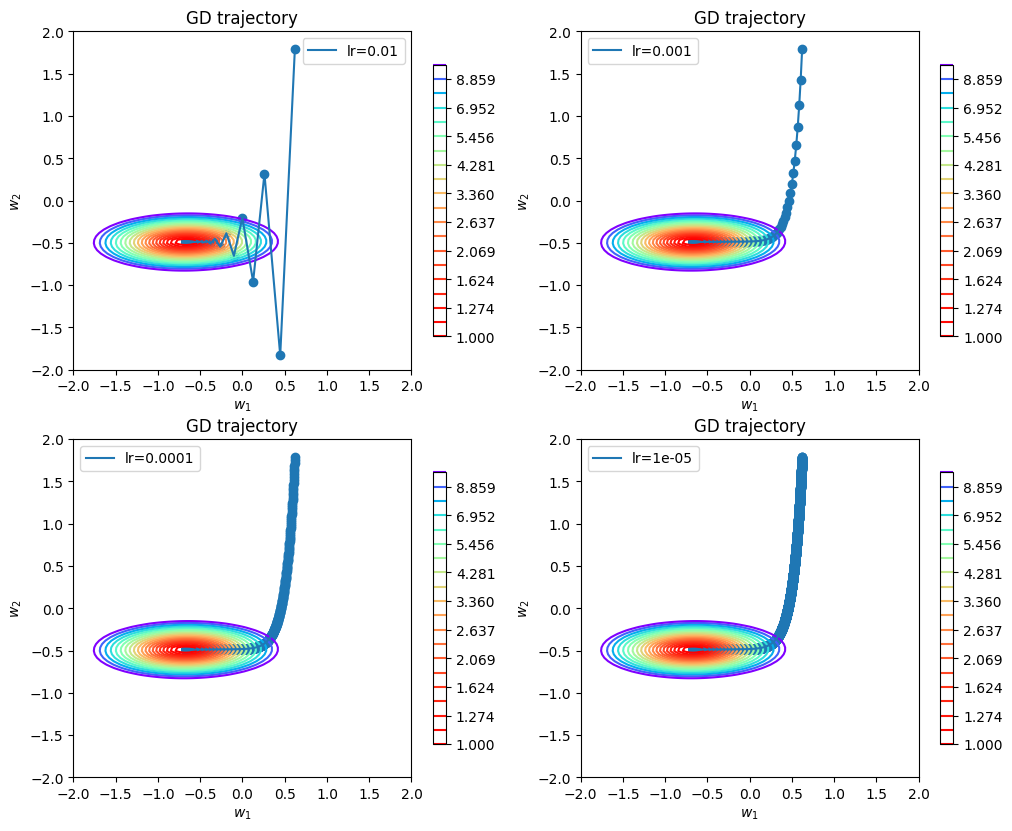

In [82]:
# пришлось немного изменить функцию для отрисовки градиентного спуска, чтобы можно было нармально нарисовать спуск для нескольких значений шага одновременно

fig = plt.figure(figsize=(12, 15))


lr_s = np.asarray([0.01, 0.001, 0.0001, 0.00001])
for i, lr in enumerate(lr_s):
    w_list = gradient_descent(w_init, X, y, loss, lr)

    ax = fig.add_subplot(3, 2, i + 1)
    plot_gd(w_list, X, y, loss, graph_title=f'lr={lr}')
plt.show();

Чем меньше шаг скорость обучения (параметр lr) градиентного спуска, тем менее хаотично становятся его шаги (см., например, 1 и 2 график).

Теперь реализуем стохастический градиентный спуск

**Задание 1.4 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent`

Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча. 

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [83]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция стохастического градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
    batch = X[batch_indices]
    y = y[batch_indices]
    w_list = [w_init]
    for _ in range(n_iterations):
        grad = loss.calc_grad(batch, y, w_list[-1])
        w_list.append(w_list[-1] - lr * grad)
    return w_list
    

**Задание 1.5 (5/8 балла):** При помощи функций `stochastic_gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`. 

Сделайте и опишите свои выводы о том, как параметры  `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

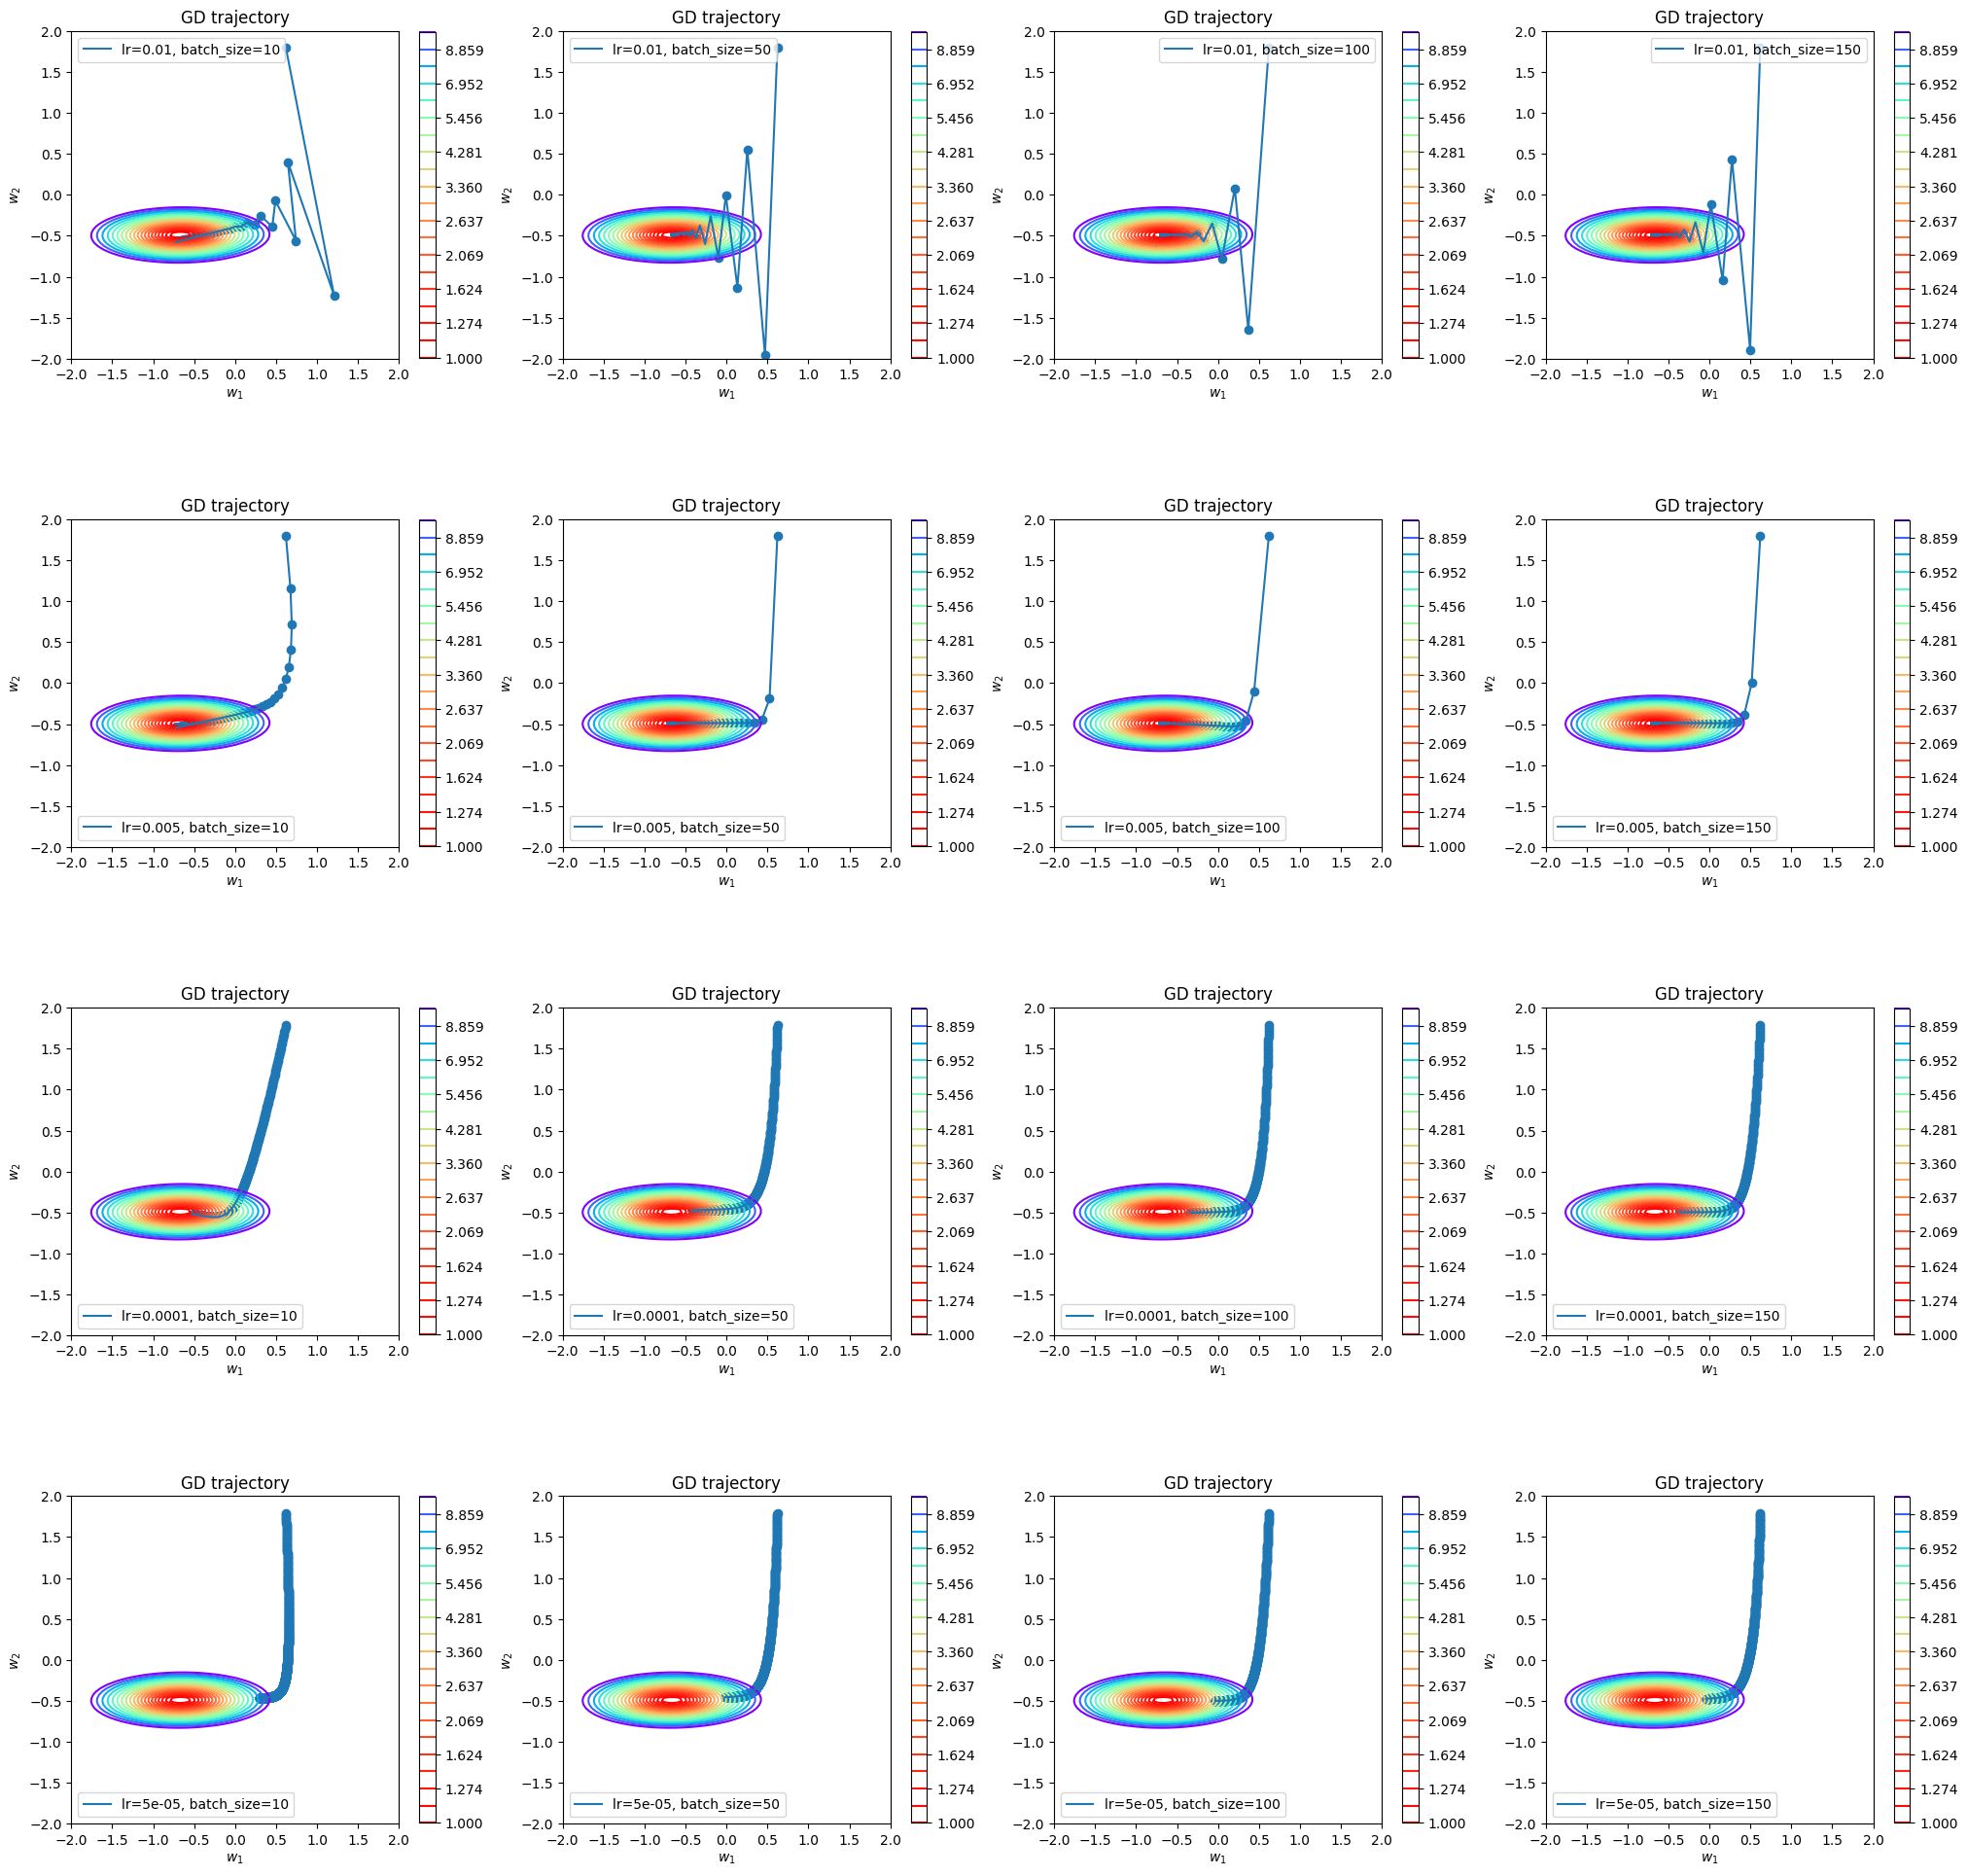

In [84]:
fig = plt.figure(figsize=(25, 25))


lr_s = np.asarray([0.01, 0.005, 0.0001, 0.00005])
batch_size_s = np.asarray([10, 50, 100, 150])
for i, lr in enumerate(lr_s):
    for j, batch_size in enumerate(batch_size_s):
        w_list = stochastic_gradient_descent(w_init, X, y, loss, lr, batch_size)
        ax = fig.add_subplot(4, 4, j + 4 * i + 1)
        plot_gd(w_list, X, y, loss, graph_title=f'lr={lr}, batch_size={batch_size}')
plt.show();

Видно, что при больших значениях темпа обучения (праметр lr), шаги градиентного спуска более хаотичны (см. первую строку графиков). При уменьшении lr и увеличении подвыборки шаги становятся более 'точными'. Шаги SGD более случайны и менее точны, в то время как для GD они изначальна нацелены на минимизацию функции ошибки.

Вы могли заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага. 

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы более точнее этого минимума достичь и не "перепрыгнуть" его. 

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

**Задание 1.6 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent` на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [85]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param p: float -- значение степени в формуле затухания длины шага
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
    batch = X[batch_indices]
    y = y[batch_indices]
    w_list = [w_init]
    for t in range(n_iterations):
        grad = loss.calc_grad(batch, y, w_list[-1])
        eta = lr * (1 / (1 + t)) ** p
        w_list.append(w_list[-1] - eta * grad)
    return w_list

**Задание 1.7 (5/8 балла):** При помощи новой функции `stochastic_gradient_descent` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска

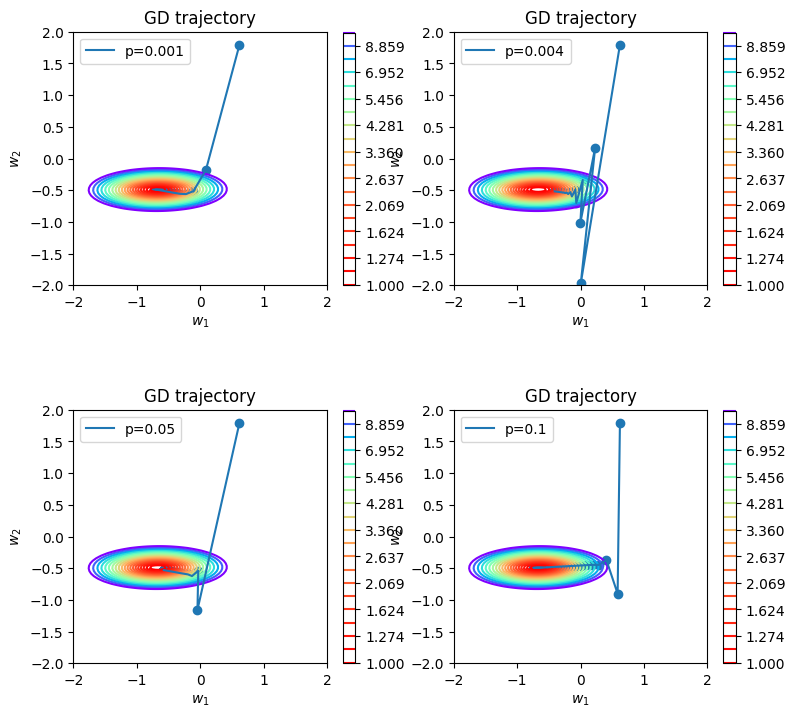

In [93]:
fig = plt.figure(figsize=(9, 9))


p_s = np.asarray([0.001, 0.004, 0.05, 0.1])
for i, p in enumerate(p_s):
    w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.01, 10, p)
    ax = fig.add_subplot(2, 2, i + 1)
    plot_gd(w_list, X, y, loss, graph_title=f'p={p}')
plt.show();

При увеличении $p$ мы уменьшаем длину шага на каждой итерации, поэтому после большого колическта итераций шаги градиентного спуска менее хоатичны.

**Задание 1.8 (5/8 балла):** Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

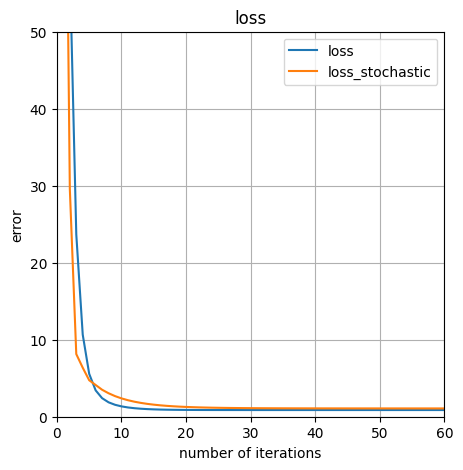

In [99]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
w_list_stochastic = stochastic_gradient_descent(w_init, X, y, loss, 0.01, 10, 0.1, 100)


losses = []
losses_stochastic = []
flag = True
for w, w_stochastic in zip(w_list, w_list_stochastic):
    losses.append(loss.calc_loss(X, y, w))
    losses_stochastic.append(loss.calc_loss(X, y, w_stochastic))

fig = plt.figure(figsize=(5, 5))
plt.plot(np.arange(len(losses)), losses, label='loss')
plt.plot(np.arange(len(losses_stochastic)), losses_stochastic, label='loss_stochastic')
plt.legend()
plt.grid(True)
plt.title('loss')
plt.ylabel('error')
plt.xlabel('number of iterations')
plt.ylim(0, 50)
plt.xlim(0, 60)
plt.show();

Видно, что на некоторых итерациях (вначале) SGD луше уменьшает ошибку. Скорее всего так получилось, что вначале SGD сделал несколько более точных шагов, а потом начал делать более хаотичные, из-за этого в некоторый момент GD его обогнал по значению уменьшения ошибки. 

## Часть 2. Линейная регрессия (5 баллов)

Теперь давайте напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`

В методе `predict` мы будем применять нашу регрессию к датасету, 

**Задание 2.1 (5/8 балла):** Допишите код в методах `fit` и `predict` класса `LinearRegression`

В методе `fit` вам нужно как-то инициализировать веса `w`, применить `gradient_descent` и сохранить последнюю `w` из траектории.

В методе `predict` вам нужно применить линейную регрессию и вернуть вектор ответов.

Обратите внимание, что объект лосса передаётся в момент инициализации и хранится в `self.loss`. Его нужно использовать в `fit` для `gradient_descent`.

In [100]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr

    def gradient_descent(self,
                         w_init: np.ndarray,
                         X: np.ndarray,
                         y: np.ndarray,
                         loss: BaseLoss,
                         lr: float,
                         n_iterations: int = 100000,
                         ) -> List[np.ndarray]:
    
        w = w_init.copy()
        history = []
        for i in range(n_iterations):
            history.append(w.copy())
            grad = loss.calc_grad(X, y, w)
            w -= lr * grad
        return history


    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        w_init = np.zeros(X.shape[1])
        self.w = w_init.copy()
        self.w = gradient_descent(self.w, X, y, self.loss, self.lr)[-1]

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        return X.dot(self.w)

Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации. 

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [101]:
linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами, который был у вас на семинарах:

In [104]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index()

In [105]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

**Задание 2.2 (5/8 балла):** Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Разделите датасет на обучающую и тестовую выборку
* Заполните пропуски
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

In [106]:
from sklearn.model_selection import train_test_split
X_raw.drop([0], axis=1, inplace=True)
X_raw.columns = X_raw.columns.astype(str)
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

In [107]:
num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

# заполнение пропущенных значений числовых признаков медианой
X_train[num_cols] = X_train[num_cols].fillna(X_train[num_cols].median())
X_test[num_cols] = X_test[num_cols].fillna(X_train[num_cols].median())

# заполнение пропущенных значений категориальных признаков самым часто встречающимся типом
X_train[cat_cols] = X_train[cat_cols].fillna(X_train[cat_cols].mode().iloc[0])
X_test[cat_cols] = X_test[cat_cols].fillna(X_train[cat_cols].mode().iloc[0])

In [108]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [109]:
# One-Hot Encoding
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)

X_train_ohe = encoder.fit_transform(X_train[cat_cols])
X_test_ohe = encoder.transform(X_test[cat_cols])

In [110]:
# объединение числовых и категориальных признаков
X_train = np.hstack((X_train[num_cols].values, X_train_ohe))
X_test = np.hstack((X_test[num_cols].values, X_test_ohe))

**Задание 2.3 (5/8 балла):** Обучите написанную вами линейную регрессию на обучающей выборке

In [111]:
lr = LinearRegression(MSELoss())
lr.fit(X_train, y_train)

**Задание 2.4 (5/8 балла):** Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке при помощи метода `mean_squared_error` из `sklearn.metrics`.

In [112]:
from sklearn.metrics import mean_squared_error

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

print(f'Train MSE: {mean_squared_error(y_train, y_pred_train)}')
print(f'Test MSE: {mean_squared_error(y_test, y_pred_test)}')

Train MSE: 1228927.96294113
Test MSE: 11400518.195312418


Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней $\ell_2$ регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

**Задание 2.5 (5/8 балла):** Реализуйте класс `MSEL2Loss`

Он должен вычислять лосс и градиент по формулам наверху

Подсказка: обратите внимание, что последний элемент вектора `w` — это bias (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак). Как мы знаем из лекций и семинаров, bias регуляризовать не нужно. Поэтому не забудьте убрать последний элемент из `w` при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и занулить его при подсчёте слагаемого $2 \lambda w$ в `calc_grad`

In [113]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета. Последний признак константный.
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии. Последний вес -- bias.
        :output: число -- значения функции потерь
        """
        # Добавляем столбец из единиц для константного признака
        return np.sum((X@w - y) ** 2) / X.shape[0] + self.coef * np.sum(w[:-1] ** 2)


    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        gp_1 = 2 * X.T@(X@w - y) / X.shape[0]
        w[-1] = 0
        gp_2 = 2 * self.coef * w
        return  gp_1 + gp_2

Теперь мы можем использовать лосс с $\ell_2$ регуляризацией в нашей регрессии, например, так:

In [114]:
linear_regression = LinearRegression(MSEL2Loss(0.1))

**Задание 2.6 (5/8 балла):** Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации. 

In [116]:
linear_regression.fit(X_train, y_train)

y_pred_train = linear_regression.predict(X_train)
y_pred_test = linear_regression.predict(X_test)

print(f'Train MSE: {mean_squared_error(y_train, y_pred_train)}')
print(f'Test MSE: {mean_squared_error(y_test, y_pred_test)}')

Train MSE: 5241931.253656661
Test MSE: 23983692.954204347


In [117]:
from tqdm import tqdm


coefs = np.logspace(-3, -1, 10)
min_errror = np.inf
best_model = None
for coef in tqdm(coefs):
    linear_regression = LinearRegression(MSEL2Loss(coef))
    linear_regression.fit(X_train, y_train)
    y_pred = linear_regression.predict(X_test)

    error = mean_squared_error(y_test, y_pred)
    if error < min_errror:
        min_errror = error
        best_coef = coef
        best_model = linear_regression

print()
print(f'Лучший коэффициент регуляризации: {best_coef}')
print(f'MSE: {min_errror}')

100%|██████████| 10/10 [00:51<00:00,  5.11s/it]


Лучший коэффициент регуляризации: 0.0027825594022071257
MSE: 8333925.131622206


In [118]:
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

print(f'Train MSE: {mean_squared_error(y_train, y_pred_train)}')
print(f'Test MSE: {mean_squared_error(y_test, y_pred_test)}')

Train MSE: 1709918.328429365
Test MSE: 8333925.131622206


Как видно ошибка при регуляризации уменьшилась, но только на тестовой выборке

В нашем датасете могут быть выбросы. На семинаре вам рассказывали, что с выбросами хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а  выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

**Задание 2.7 (5/8 балла):** Реализуйте класс `HuberLoss`

Он должен вычислять лосс и градиент по формулам наверху

In [119]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        """
        :param eps: параметр huber loss из формулы
        """
        self.eps = eps

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """
        psi = np.vectorize(lambda z: z ** 2 / 2 if -self.eps < z < self.eps else self.eps * (np.abs(z) - 0.5 * self.eps))
        z = X@w - y
        return np.sum(psi(z)) / X.shape[0]


    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        grad_psi = np.vectorize(lambda z: z if -self.eps < z < self.eps else self.eps * np.sign(z))
        grad_z = grad_psi(X@w - y)
        return X.T@grad_z / X.shape[0]

**Задание 2.8 (5/8 балла):** Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [122]:
from tqdm import tqdm


eps_s = np.logspace(-0.5, 2.5, 5)
min_errror = np.inf
best_model = None
for eps in tqdm(eps_s):
    linear_regression = LinearRegression(HuberLoss(eps))
    linear_regression.fit(X_train, y_train)
    y_pred = linear_regression.predict(X_test)

    error = mean_squared_error(y_test, y_pred)
    if error < min_errror:
        min_errror = error
        best_coef = eps
        best_model = linear_regression

print()
print(f'Лучший коэффициент регуляризации: {best_coef}')
print(f'MSE: {min_errror}')

100%|██████████| 5/5 [04:54<00:00, 58.94s/it]


Лучший коэффициент регуляризации: 56.23413251903491
MSE: 8721751.256336533


In [123]:
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)


print(f'Train MSE: {mean_squared_error(y_train, y_pred_train)}')
print(f'Test MSE: {mean_squared_error(y_test, y_pred_test)}')

Train MSE: 2118324.851778187
Test MSE: 8721751.256336533


Ошибка стала больше на обоих выборках

**Задание 3 (0.08/8 балла)**
Вставьте ваш любимый мем 2021 в ячейку ниже:

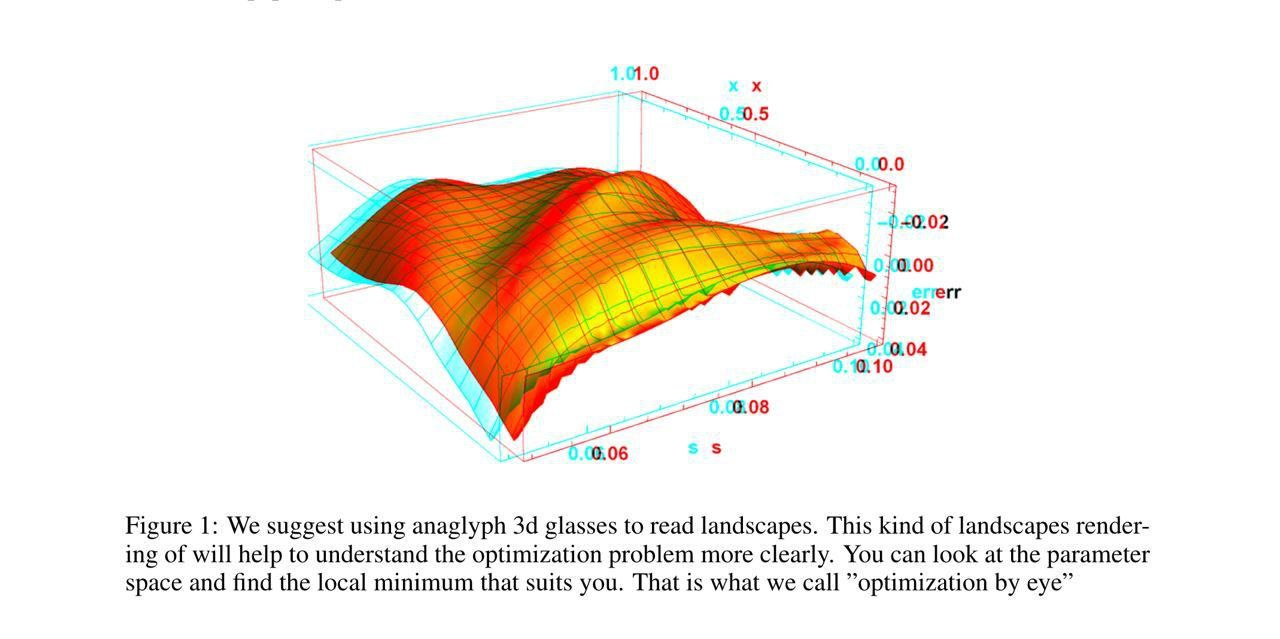

### БОНУС (2.5 баллов)

Градиентный спуск — далеко не единственный метод оптимизации. 
Другой очень известный метод называется ["Алгоритм имитации отжига"](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B8%D0%BC%D0%B8%D1%82%D0%B0%D1%86%D0%B8%D0%B8_%D0%BE%D1%82%D0%B6%D0%B8%D0%B3%D0%B0). Он не так часто используется для оптимизации моделей машинного обучения, но у вас есть уникальная возможность попробовать применить его к нашей любимой линейной регрессии.

**Задание (2.5 баллов)**:
Напишите алгоритм имитации отжига для оптимизации MSE линейной регрессии. 

Сравните результат с градиентным спуском по "траектории" и по финальному лоссу.

Подсказка: каждую новую точку (веса регресси в нашем случае) можно семплировать из некоторого случайного распределением с центром в текущей точке. Хорошо подойдут распределения с "тяжёлыми" хвостами, например, распределение Стьюдента с параметром количества степеней свободы в районе 3.
Это может выглядеть, например, так:
```
new_w = old_w + np.random.standard_t(3, size=old_w.shape)
```
С параметром распределения можно поэксперементировать: чем он больше, тем реже новые точки будут очень сильно уходить от старых.

P.S. Реализация метода имитации отжига доступна как функция anneal (англ. отжиг) в модуле optimize библиотеки SciPy.

In [124]:
import numpy as np
from sklearn.metrics import mean_squared_error


def simulated_annealing(X, y, init_w, T=1.0, alpha=0.9, decay_rate=0.99, num_iter=10000):
    """
    Алгоритм имитации отжига для оптимизации MSE линейной регрессии:
    1. Инициализация начальных весов модели случайным образом.
    2. Задание начальной температуры T и параметров охлаждения alpha и decay_rate.
    3. На каждой итерации:
        - Генерация новых весов с помощью случайного распределения, центрированного в текущих весах.
        - Вычисление лосса на новых весах.
        - Если лосс на новых весах меньше, чем на текущих, то принимаем новые веса.
        - Если лосс на новых весах больше, чем на текущих,
                то принимаем новые веса с некоторой вероятностью,
                зависящей от разницы лоссов и текущей температуры.
                Чем выше температура или разница лоссов, тем больше вероятность принятия худших решений.
        - Охлаждение температуры.
    4. Возвращение найденных весов с наименьшим лоссом.
    """
    losses = []
    current_w = init_w
    current_loss = mean_squared_error(y, X @ current_w)
    best_w = current_w
    best_loss = current_loss
    
    for i in range(num_iter):
        new_w = current_w + np.random.standard_t(3, size=current_w.shape)
        new_loss = mean_squared_error(y, X @ new_w)

        if new_loss < best_loss:
            best_w = new_w
            best_loss = new_loss
        
        if new_loss < current_loss:
            current_w = new_w
            current_loss = new_loss
        elif np.exp((current_loss - new_loss) / T) > np.random.rand():
            current_w = new_w
            current_loss = new_loss
        
        losses.append(current_loss)
        T *= alpha
        T = max(T, decay_rate)
        
    return best_w, losses

In [125]:
np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

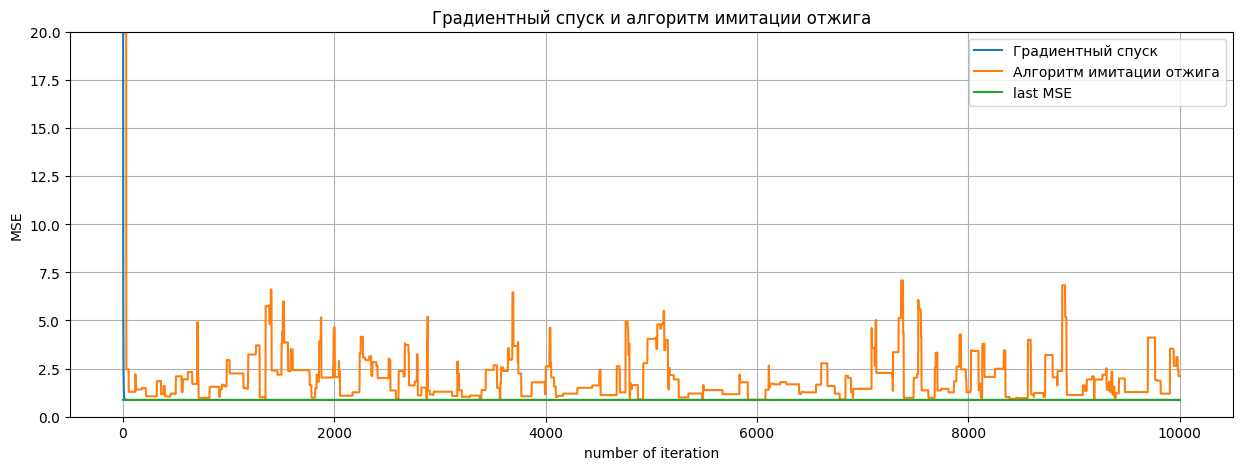

In [126]:
plt.figure(figsize=(15, 5))

# Градиентный спуск
init_w = w_init
num_iter = 10000
w = init_w.copy()
lr = 0.01
losses = []
for i in range(num_iter):
    grad = 2 * X.T @ (X @ w - y) / y.size
    w -= lr * grad
    loss = mean_squared_error(y, X @ w)
    losses.append(loss)

plt.plot(losses, label='Градиентный спуск')

# Алгоритм имитации отжига
w, losses = simulated_annealing(X, y, init_w, num_iter=num_iter)
plt.plot(losses, label='Алгоритм имитации отжига')

loss = mean_squared_error(y, X @ w)
plt.plot([loss] * num_iter, label='last MSE')

plt.ylim(0, 20)
plt.legend()
plt.grid()
plt.title('Градиентный спуск и алгоритм имитации отжига')
plt.xlabel('number of iteration')
plt.ylabel('MSE')
plt.show()

Результаты сравнения могут зависеть от конкретных данных и параметров градиентного спуска и алгоритма имитации отжига, но в общем случае можно ожидать, что градиентный спуск будет сходиться быстрее, но может застревать в локальных минимумах, тогда как алгоритм имитации отжига может позволить выбраться из таких локальных минимумов и найти глобальный минимум. Однако, за счет большей случайности алгоритм имитации отжига может потребовать большего числа итераций/эпох для достижения хорошего результата.

Например, на графике выше видно, что в среднем алгоритм имитации отжига уменьшает ошибку с увеличением номера итерации.